In [40]:
%matplotlib inline
import numpy as np
import sklearn as skl
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
sns.set_style('darkgrid')


資料預處理

In [41]:
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.preprocessing import LabelEncoder as LE
train_path = './TraData.csv'
data = pd.read_csv(train_path, sep=',')
label = data.click
del data['click'] # 記得別讓答案變成一組 feature ，這樣 model 就直接看到答案了
# 特徵選擇、降維 改交給 SVD 分解完成
del data['spaceCat']
del data['adType']
del data['os']
del data['deviceType']
del data['publisherId']
del data['dclkVerticals']
del data['campaignId']
del data['advertiserId']
le_list = {}
for key, value in data.iteritems():
    le_list[key] = LE() ## 字串特徵轉屬性資料（類別）
    data[key] = le_list[key].fit_transform(value) ## csv 檔中 feature 均為屬性資料

ohe = OHE() # 屬性資料是離散資料，進入 SVM, MLP 等模型之前必須轉獨熱編碼
data = ohe.fit_transform(data)
print data[:3] ## 印出隨機三筆資料觀察

pos_num = np.sum(label==1)
neg_num = len(label)-pos_num
pos_r = pos_num / float(len(label))
neg_r = neg_num / float(len(label))
print pos_r, neg_r # 印出類別權重


  (0, 106332)	1.0
  (0, 67)	1.0
  (0, 3)	1.0
  (0, 1)	1.0
  (1, 222395)	1.0
  (1, 200)	1.0
  (1, 3)	1.0
  (1, 1)	1.0
  (2, 272907)	1.0
  (2, 229)	1.0
  (2, 3)	1.0
  (2, 1)	1.0
0.000616772252945 0.999383227747


設定模型參數、建構模型

In [42]:
def build_model(input_size):
    model = Sequential()
    # model.add(Flatten(input_shape=[input_size]))
    model.add(Dropout(0.14, input_shape=[input_size])) ## 訓練時，隨機無視一些輸入資料 (設成 0)，可以減少 overfitting
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) 
    ## 訓練時，把一些 weight 的傳遞在 forward-pass 時取消 (weight 設成 0) ，在 backward-pass 的時候不將 loss 傳遞回去，
    ## 除了可以當作一種 regularization 減少 overfitting，也可以視為一種 bagging 手段
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
    return model

earlyStopping = EarlyStopping(monitor='loss', patience=3, mode='auto')

3-fold Cross-validation

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
rds = RandomUnderSampler()
# rds = SMOTE()
svd = TruncatedSVD(n_components=100) # 降維，維度太高會發生'維度災難'
cvscores = []
kfold = StratifiedKFold(n_splits=3, shuffle=True)
first=True
for train, test in kfold.split(data, label):
    # Fit the data
    X, y = rds.fit_sample(data[train], label[train])
    X = svd.fit_transform(X)
    print 'info: %.2f'%np.sum(svd.explained_variance_ratio_)
    # Build the model
    model = build_model(X.shape[1])
    if first:
        model.summary()
        first=False
    # Train the model
    model.fit(X, y, epochs=100, batch_size=64, verbose=1, callbacks=[earlyStopping])
    # evaluate the model
    pred = model.predict(svd.transform(data[test]), verbose=0)
    pred[pred<0.5] = 0
    pred[pred>0] = 1
    score = f1_score(pred, label[test])
    print("f1: %.4f%%"%(np.clip(score*100.,0.,100.)))
    cvscores.append(score)
print("f1.avg: %.4f%% (+/- %.4f%%)" % (np.mean(cvscores)*100., np.std(cvscores)*100.))

info: 0.56
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_149 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 128)               12928     
_________________________________________________________________
dropout_150 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_151 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_152 (Dropout)        (None, 128)               0         

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.33333333333)
X_train, Y_train = rds.fit_sample(X_train, Y_train)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)
model = build_model(X_train_svd.shape[1])
model.fit(X_train_svd, Y_train)
predicted = model.predict(X_test_svd).flatten()
predicted[predicted<0.5] = 0
predicted[predicted>0] = 1
confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
inclass_precision = skl.metrics.classification_report(Y_test, predicted)
score = f1_score(predicted,Y_test)
print(confusion_metrix)
print(inclass_precision)
print(score)

Epoch 1/10
802/802 [==============================] - 2s 3ms/step - loss: 0.7059 - acc: 0.5025
Epoch 2/10
802/802 [==============================] - 0s 291us/step - loss: 0.6883 - acc: 0.5362
Epoch 3/10
802/802 [==============================] - 0s 277us/step - loss: 0.6754 - acc: 0.5873
Epoch 4/10
802/802 [==============================] - 0s 286us/step - loss: 0.6442 - acc: 0.6397
Epoch 5/10
802/802 [==============================] - 0s 269us/step - loss: 0.6047 - acc: 0.6995
Epoch 6/10
802/802 [==============================] - 0s 297us/step - loss: 0.5717 - acc: 0.7132
Epoch 7/10
802/802 [==============================] - 0s 306us/step - loss: 0.5384 - acc: 0.7232
Epoch 8/10
802/802 [==============================] - 0s 306us/step - loss: 0.5327 - acc: 0.7294
Epoch 9/10
802/802 [==============================] - 0s 271us/step - loss: 0.5158 - acc: 0.7319
Epoch 10/10
802/802 [==============================] - 0s 323us/step - loss: 0.4778 - acc: 0.7743
[[277220  43074]
 [    62    13

SVD 分解、可視化

In [44]:
def plot_embedding(x_emb,y,n,title=''): ## visualization
    cmap = plt.cm.gist_ncar_r
    ax = plt.subplot()
    for l in xrange(n):
        points = x_emb[y==l,:]
        ax.scatter(points[:,0], points[:,1], label=l, c=cmap(float(l)/float(n)))
    ax.legend(loc='lower right', frameon=True, prop={'size': 10})
    ax.set_title(title)
    plt.show()

In [45]:
svdvis = TruncatedSVD(n_components=2)
embedding = svdvis.fit_transform(X_test)

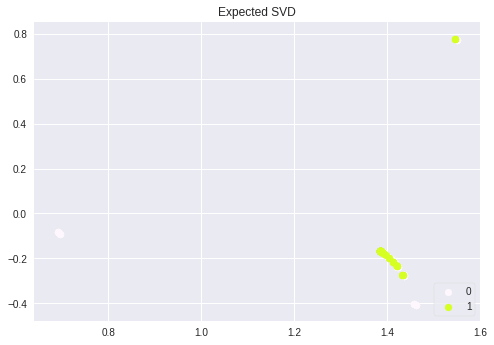

In [9]:
plot_embedding(embedding, Y_test, 2, 'Expected SVD') ## 視覺化, 看起來幾乎不是線性可分的

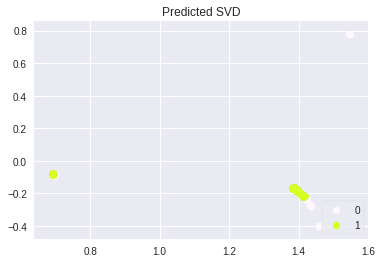

In [46]:
confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
inclass_precision = skl.metrics.classification_report(Y_test, predicted)
plot_embedding(embedding, predicted, 2, 'Predicted SVD')

看來挺糟糕的 :\

補充從 R script 得到的這份 training data 的 ANOVA 結果（從九十萬筆資料隨機抽樣5000筆資料）：

```R
               Df Sum Sq  Mean Sq   F value Pr(>F)    
adx             1  0.000 0.000003 2.192e+23 <2e-16 ***
spaceType       1  0.000 0.000011 9.356e+23 <2e-16 ***
spaceId       128  0.516 0.004034 3.451e+26 <2e-16 ***
ip           4839  3.480 0.000719 6.154e+25 <2e-16 ***
os              3  0.000 0.000000 2.000e-03 0.9999    
campaignId      1  0.000 0.000000 3.089e+00 0.0911 .  
advertiserId    1  0.000 0.000000 1.496e+00 0.2327    
Residuals      25  0.000 0.000000                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
```

可以看出 adx, spaceType, spaceId, ip 對 click 的影響似乎是顯著的？

也許可以實驗看看只選擇 adx, spaceType, spaceId, ip 當作 feature？或是使用 PCA 做降維？

因為他們對 click 的影響較顯著？ p<0.05